In [1]:
import os
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "mangaki.settings")

'mangaki.settings'

In [2]:
from mangaki.utils.als import MangakiALS
from mangaki.utils.data import Dataset
from mangaki.utils.algo import fit_algo
import numpy as np

#ratings = Rating.objects.values_list('user_id', 'work_id', 'choice')
#fit_algo('als', ratings)
#algo = MangakiALS(20)
#algo.load(algo.get_backup_filename())
#dataset = Dataset()
#dataset.load('ratings-' + algo.get_backup_filename())

dataset = Dataset()
dataset.load_csv('ratings-ordered.csv', convert=np.int64, title_filename='works-ordered.csv')

In [3]:
ratings_for = {}
for (user_id, work_id), choice in zip(dataset.anonymized.X, dataset.anonymized.y):
    ratings_for.setdefault(work_id, []).append(choice)

In [4]:
from mangaki.utils.efa import MangakiEFA

efa = MangakiEFA()
efa.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
efa.fit(dataset.anonymized.X, dataset.anonymized.y, truncated=100)

Computing M: (2020 × 9310)
Shapes (2020, 20) (20, 100)
Chrono: factor matrix [0q, 213ms]


In [30]:
efa.model.mean_.shape

(100,)

In [6]:
class Tree:
    def __init__(self):
        pass

    def get_bulk(self, history=None):
        if history is None:
            return [13, 15, 131, 137, 8765]
        else:
            print('second run')
            return [2569, 2336, 3393, 3400, 1089]

In [372]:
import numpy as np

class NewUser:
    def __init__(self, model, my_user_id, truth):
        self.user_id = my_user_id
        self.model = model
        self.truth = truth
        self.history = []
        # clf = LinearRegression(fit_intercept=False)
        # clf2 = LogisticRegression(fit_intercept=False)
        """if len(set(yl)) >= 2:
            happened += 1
            clf2 = LogisticRegression(fit_intercept=False)
            # clf.fit(X, y)
            clf2.fit(X, yl)
            clf.coef_ = clf2.coef_
            clf.intercept_ = 0."""

    def ask(self, work_ids):
        # r_bonus
        # self.model = MangakiALS(NB_COMPONENTS)
        # self.model.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
        # self.model.fit(dataset.anonymized.X[r_train + r_bonus], dataset.anonymized.y[r_train + r_bonus])
        replied = []
        choices = []
        for work_id in work_ids:
            if work_id in self.truth:
                replied.append(work_id)
                choices.append(self.truth[work_id])
        self.history.append((work_ids, replied, choices))
        #print(replied, choices)
        #print('Reply rate', len(choices) / len(work_ids))
#        mean = np.mean(choices)
#        self.model.means[self.user_id] = mean
        mean = 0
        bonus_ratings = {self.user_id: {work_id: choice - mean for work_id, choice in zip(work_ids, choices)}}
        #print(bonus_ratings)
        #self.model.fit_user(self.user_id, bonus_ratings)
        remaining_work_ids = list(set(self.truth.keys()) - set(work_ids))
        n = len(remaining_work_ids)
        self.n = n
        clf = LogisticRegression(fit_intercept=True, C=1000)
        self.clf = clf
        X = self.model.H.T[replied]
        y = choices
        #print(replied, choices, y)
        try:
            clf.fit(X, y)
            y_pred = clf.predict(self.model.H.T[remaining_work_ids])
        except ValueError:
            y_pred = [y[0]] * n
        y_true = [self.truth[work_id] for work_id in remaining_work_ids]
        #print(y_pred, y_true)
        self.acc = sum(p == t for p, t in zip(y_pred, y_true)) / n
        y_best_pred = np.round(self.model.predict(np.array([(self.user_id, work_id) for work_id in remaining_work_ids])))
        self.best_acc = sum(p == t for p, t in zip(y_best_pred, y_true)) / n
        #print('acc', self.acc)
        #print('comp', clf.coef_)
    
    def predict(self, work_ids):
        return self.model.predict(np.array([[self.user_id, work_id] for work_id in work_ids]))

    def get_truth(self, work_ids):
        return [self.truth.get(work_id) for work_id in work_ids]
    
    def compute_error(self, work_ids):
        y_pred = self.predict(work_ids)
        #print(y_pred)
        y_true = self.get_truth(work_ids)
        #print('was:', y_true)
        return self.model.compute_rmse(y_pred, y_true)
    
    def get_history(self):
        flat_history = {}
        for work_ids, replied, choices in self.history:
            for work_id, choice in zip(replied, choices):
                flat_history[work_id] = choice
        return flat_history

In [357]:
from collections import defaultdict

def get_truth(tracked_user_ids, dataset):
    truth = defaultdict(dict)
    for (user_id, work_id), choice in zip(dataset.anonymized.X, dataset.anonymized.y):
        if work_id < 100:
            truth[user_id][work_id] = choice
    return truth

In [358]:
truth = get_truth([], dataset)

In [359]:
kept_user_ids = [user_id for user_id in truth if len(truth[user_id]) > 75]

In [360]:
def get_volume(vectors):
    return np.linalg.det(vectors.dot(vectors.T))

In [361]:
from mangaki.utils.dpp2 import MangakiDPP

dpp = MangakiDPP(efa.H.T)
dpp.compute_similarity()
dpp.preprocess()

In [362]:
np.mean(efa.W, axis=0)

array([ -5.53462666e-17,  -2.39721609e-16,  -2.37323912e-16,
         8.91750920e-18,   5.29279590e-17,   5.03722476e-17,
         1.91815760e-17,  -1.01431514e-16,   1.00249841e-16,
         7.87873617e-17,  -8.67018228e-18,  -6.70530738e-18,
        -1.62239584e-17,   1.02091053e-17,  -4.45188441e-18,
         7.51633354e-17,  -1.97174510e-17,   5.33126898e-18,
         5.26256706e-17,   7.24530447e-17])

In [363]:
mean_theta = np.mean(efa.W[kept_user_ids], axis=0)

In [446]:
NB_WORKS = 10
TRACKED_SET = tuple(dpp.sample_k(NB_WORKS))

In [447]:
from math import exp

th = mean_theta
w = np.matrix(efa.H.T)

def fisher_matrix(subset):
    return np.sum(exp(w[i].dot(th)) / (1 + exp(w[i].dot(th))) ** 2 * w[i].T.dot(w[i]) for i in subset)

In [448]:
from itertools import combinations
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

#JURY = [137, 1089, 2569, 2336, 3393, 3400, 3900, 242]

algo = efa
records = []

user_ids = random.sample(kept_user_ids, 30)
truth = get_truth(user_ids, dataset)

# ALS train
#user.compute_error(JURY)
# Restart with multistage tree
#tree = Tree()
#work_ids = tree.get_bulk()

tuples = [tuple(random.sample(range(100), NB_WORKS)) for _ in range(100)]
tuples += [TRACKED_SET]

values = defaultdict(lambda: defaultdict(list))
for user_id in user_ids:
    user = NewUser(algo, user_id, truth[user_id])
    #work_ids = list(truth.keys())[:5]
    for work_ids in tuples:
        #print(work_ids)
        user.ask(list(work_ids))
        """if work_ids == TRACKED_SET:
            print(user.history[-1])"""
        #values[work_ids]['mean_user_std_dev'].append(np.std(user.get_truth(work_ids)))
        #values[work_ids]['rmse'].append(user.compute_error(list(set(user.truth.keys()) - set(work_ids))))
        values[work_ids]['vol'].append(get_volume(algo.H.T[list(work_ids)]))
        values[work_ids]['remaining'].append(user.n)
        values[work_ids]['acc'].append(user.acc)
        values[work_ids]['best_acc'].append(user.best_acc)

for work_ids in tuples:
    record = {key: np.mean(values[work_ids][key]) for key in values[work_ids]}
    record['worst_acc'] = np.min(values[work_ids]['acc'])
    record['std_acc'] = np.std(values[work_ids]['acc'])
    record['fisher_det'] = np.linalg.det(fisher_matrix(work_ids))
    record['fisher_tr'] = np.trace(fisher_matrix(work_ids))
    record['work_ids'] = work_ids
    record['is_tracked'] = work_ids == TRACKED_SET
    record['mean_work_std_dev'] = np.mean([np.std(ratings_for[work_id]) for work_id in work_ids])
    records.append(record)

records.sort(key=lambda record: record['acc'])
#history = user.get_history()
#print(history)
#for w1, w2 in combinations(history.keys(), 2):
#    print(w1, w2, algo.VT.T[w1].dot(algo.VT.T[w2]))
#user.compute_error(work_ids)
#work_ids = tree.get_bulk(user.get_history())
#print(work_ids)
#user.ask(work_ids)
#user.compute_error(work_ids)
#user.compute_error(JURY)

In [449]:
records.sort(key=lambda record: record['acc'], reverse=True)

In [454]:
from IPython.display import display

df = pd.DataFrame(records)
display(df.sort_values('acc', ascending=False))

,acc,best_acc,fisher_det,fisher_tr,is_tracked,mean_work_std_dev,remaining,std_acc,vol,work_ids,worst_acc
0,0.680743,0.836408,-9.819054e-207,0.191173,False,0.470219,81.700000,0.086151,2.272438e-16,"(3, 48, 23, 58, 40, 74, 12, 28, 36, 98)",0.444444
1,0.676918,0.841419,-2.662272e-206,0.183356,False,0.467049,81.500000,0.097312,9.723498e-17,"(98, 17, 47, 23, 7, 62, 58, 71, 77, 15)",0.487805
2,0.675775,0.834343,-6.853925e-204,0.210227,False,0.494718,80.933333,0.110060,4.445953e-15,"(24, 63, 45, 48, 91, 7, 9, 36, 43, 56)",0.437500
3,0.675769,0.840626,-1.616544e-206,0.172181,False,0.475505,81.066667,0.108128,1.040831e-16,"(78, 95, 87, 22, 15, 17, 64, 9, 11, 25)",0.469136
4,0.675683,0.839568,1.338773e-208,0.172021,False,0.475403,81.233333,0.089358,1.387025e-17,"(36, 27, 98, 21, 71, 95, 55, 93, 29, 23)",0.477778
5,0.674277,0.834108,-5.350577e-202,0.233218,False,0.488799,81.733333,0.105924,4.168093e-13,"(18, 35, 74, 5, 81, 11, 54, 80, 2, 91)",0.506329
6,0.673827,0.834542,7.307075e-204,0.190720,False,0.479503,81.733333,0.104658,2.470066e-14,"(58, 57, 83, 36, 15, 68, 82, 12, 90, 0)",0.460674
7,0.673743,0.838452,2.660444e-207,0.154194,False,0.486099,81.066667,0.104305,3.355848e-17,"(34, 25, 26, 52, 53, 22, 39, 69, 85, 97)",0.506024
8,0.671672,0.838306,1.344483e-204,0.202226,False,0.473518,81.000000,0.083573,1.180686e-16,"(83, 1, 16, 6, 92, 46, 68, 31, 4, 97)",0.494382
9,0.671404,0.840417,-5.201797e-209,0.146478,False,0.453810,81.066667,0.096276,4.162531e-19,"(2, 98, 7, 54, 24, 37, 22, 31, 64, 56)",0.518987


In [68]:
for line in zip(values[TRACKED_SET]['acc'], values[TRACKED_SET]['best_acc']):
    print(line)

(0.77000000000000002, 0.85999999999999999)
(0.68999999999999995, 0.79000000000000004)
(0.61842105263157898, 0.88157894736842102)
(0.66304347826086951, 0.84782608695652173)
(0.57446808510638303, 0.8936170212765957)
(0.64473684210526316, 0.82894736842105265)
(0.98958333333333337, 0.98958333333333337)
(0.55421686746987953, 0.77108433734939763)
(0.6588235294117647, 0.75294117647058822)
(0.64935064935064934, 0.81818181818181823)
(0.60999999999999999, 0.84999999999999998)
(0.65217391304347827, 0.95652173913043481)
(0.58695652173913049, 0.81521739130434778)
(0.797752808988764, 0.8764044943820225)
(0.66304347826086951, 0.81521739130434778)
(0.66249999999999998, 0.80000000000000004)
(0.71250000000000002, 0.82499999999999996)
(0.79591836734693877, 0.87755102040816324)
(0.92592592592592593, 0.9135802469135802)
(0.79347826086956519, 0.88043478260869568)
(0.64130434782608692, 0.86956521739130432)
(0.66233766233766234, 0.89610389610389607)
(0.79569892473118276, 0.90322580645161288)
(0.62222222222222

In [124]:
dataset.titles[np.array([45, 23, 64, 67, 4, 52])]

array(['Fullmetal Alchemist: Brotherhood OVA Collection', 'Durarara!!',
       'Yu-Gi-Oh! GX', 'IS: Infinite Stratos', 'Le Voyage de Chihiro',
       'Fate/Zero 2nd Season'], dtype=object)

In [77]:
df = df.sort_values('rmse', ascending=True)

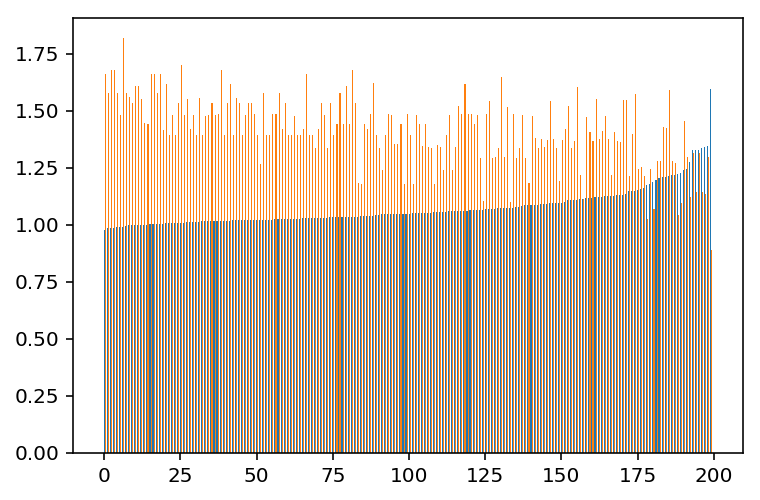

In [45]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(len(df))
width = 0.35

plt.bar(ind, df['rmse'], width)
plt.bar(ind + width, df['std_dev'], width)
plt.show()

In [12]:
dataset.titles = {}
for work_id, title in Work.objects.values_list('id', 'title'):
    dataset.titles[work_id] = title

In [20]:
sorted([key, dataset.titles[dataset.decode_work[key]], truth[key]] for key in truth.keys())[:15]

[[13, 'Death Note', 2.0],
 [53, 'Berry Dynamite', 2.0],
 [74, 'Magi - The Labyrinth of Magic', 2.0],
 [242, 'Naruto', 0.10000000000000001],
 [364, 'Gourmet solitaire (le)', 2.0],
 [400, 'Tokyo ghoul', 2.0],
 [445, '20th century boys', 0.10000000000000001],
 [449, 'Lost Paradise', 0.10000000000000001],
 [517, 'Monster', 2.0],
 [571, 'Acid Town', 0.5],
 [588, 'Nausicaa', 2.0],
 [704, 'Bride Stories', 2.0],
 [716, "Vision d'Escaflowne", 0.10000000000000001],
 [717, 'Bamboo Blade', 0.5],
 [718, 'To Love', -2.0]]

In [98]:
dataset.anonymized.X

array([[ 852, 5546],
       [1596, 8593],
       [1036, 6178],
       ..., 
       [ 426,  401],
       [1139, 5611],
       [ 665, 9257]])